In this notebook, we will build a baseline SVM model and check its performance and then conduct a grid search to derive the most optimal hyperparameters( We will try to keep the grid search training time approximately the same for SVM and MLP to ensure fair comparision). The optimal SVM will then be tested along with the optimal MLP.

In [1]:
#Import necessary libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import GroupKFold, train_test_split, GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Filter out warnings
import warnings
warnings.filterwarnings('ignore')

#Measuring time
import time

#Saving and loading models in a compressed format
from joblib import dump
from joblib import load

In [2]:
#Read the created datasets
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X_train_smote = pd.read_csv('X_train_smote.csv')
y_train_smote = pd.read_csv('y_train_smote.csv')

In [3]:
base_svc = SVC(kernel = 'linear', random_state = 42)
base_svc.fit(X_train_smote.values, y_train_smote.values.ravel())

SVC(kernel='linear', random_state=42)

In [4]:
#Statistics report for baseline SVM model1 (training)
print(classification_report(y_test, base_svc.predict(X_test.values)))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       100
           1       0.68      0.74      0.71        54

    accuracy                           0.79       154
   macro avg       0.77      0.78      0.77       154
weighted avg       0.79      0.79      0.79       154



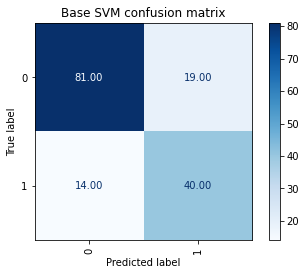

In [5]:
#Make predictions of  on the test set
y_pred = base_svc.predict(X_test)

#Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=base_svc.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2f', xticks_rotation='vertical')
disp.ax_.set_title('Base SVM confusion matrix')
plt.show()


In [6]:
#Defining the SVM hyperparameter for grid search

parameters = {
    'kernel': ('linear', 'rbf', 'poly'),
    'C': [0.1, 1, 10, 60],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto', 1, 0.1]
}

In [7]:
#Optimise the hyperparameters by grid search

svc = SVC(random_state=0)
gs = GridSearchCV(svc, parameters, cv=10, refit=True)

#Train the SVM

starttime = time.time()
gs.fit(X_train_smote, y_train_smote.values.ravel())
endtime = time.time()

In [8]:
#Printing the time taken to train the SVM
print(f"Runtime of the program is {endtime - starttime}")

Runtime of the program is 1173.7475740909576


In [9]:
#See the best score and the parameters
print(gs.best_score_, gs.best_params_)

0.865 {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


In [10]:
#See the score of the best model on the train set
gs.score(X_train_smote,y_train_smote)

0.9325

In [11]:
#Save the optimised model as a file
dump(gs, 'SVM_optimised.joblib')

['SVM_optimised.joblib']

In [12]:
#Visualise the results of Cross Validation
results = pd.DataFrame(gs.cv_results_)
results = results[['param_C','param_degree','param_gamma','param_kernel','mean_test_score']]
results.columns = ['C','degree','gamma','kernel','score']
results

,C,degree,gamma,kernel,score
0,0.1,2,scale,linear,0.74125
1,0.1,2,scale,rbf,0.76625
2,0.1,2,scale,poly,0.57750
3,0.1,2,auto,linear,0.74125
4,0.1,2,auto,rbf,0.76625
...,...,...,...,...,...
187,60,5,1,rbf,0.86500
188,60,5,1,poly,0.76375
189,60,5,0.1,linear,0.74000
190,60,5,0.1,rbf,0.85125


In [13]:
results.to_csv('resultsSVM.csv')
#Saving the result to CSV

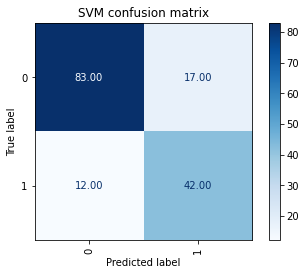

In [14]:
#Train the SVM model,using the optimal hyperparameters
svc = SVC(kernel=gs.best_params_['kernel'], C=gs.best_params_['C'], random_state=0)
svc.fit(X_train_smote, y_train_smote)

#Generate predictions on the test data using the trained model
y_pred = svc.predict(X_test)

#Generate confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot(cmap=plt.cm.Blues, values_format='.2f', xticks_rotation='vertical')
disp.ax_.set_title('SVM confusion matrix')
plt.show()

In [15]:
#Calculate precision, recall, F1-score, and support
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

#Print the results
print('precision', precision, '\nrecall', recall, '\nF1', f1, '\nsupport', support)

precision [0.87368421 0.71186441] 
recall [0.83       0.77777778] 
F1 [0.85128205 0.74336283] 
support [100  54]


<Figure size 432x288 with 0 Axes>

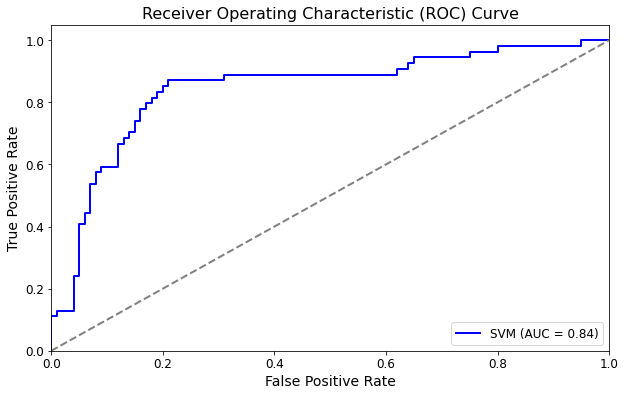

In [16]:
#Getting the best model
best_model = gs.best_estimator_

#Getting the decision scores on the test set
decision_scores = best_model.decision_function(X_test)

#Calculate false positive rate, true positive rate, and threshold
fpr, tpr, thresholds = roc_curve(y_test, decision_scores)

#Calculate AUC
roc_auc = auc(fpr, tpr)

#Plotting the ROC curve
plt.figure()
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='SVM (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate', fontsize=14)
ax.set_ylabel('True Positive Rate', fontsize=14)
ax.set_title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc="lower right", fontsize=12)
plt.show()